In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import generate_figure, test_partial
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-03-15 19:00:51.191964: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 19:00:51.191997: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
data1 = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/geneExp_NMA.csv")
data2 = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/efeature_NMA.csv")
type1 = np.array(data1['ttype'])
type2 = np.array(data2['ttype'])
data1 = np.array(data1)
data2 = np.array(data2)
data1 = data1[:, 1:21]
data2 = data2[:, 1:21]

# Sampling
idx = np.random.choice(range(data1.shape[0]), 100, replace=False)
data1, data2, type1, type2 = (x[idx] for x in (data1, data2, type1, type2))

# Preprocessing
data1 = preprocessing.normalize(data1, axis=0)
data2 = preprocessing.normalize(data2, axis=0)
std = lambda x: (1 + x) / 2
data1 = std(data1).astype(float)
data2 = std(data2).astype(float)

dataset = [data1, data2]
labels = [type1,type2]

# ComManDo

In [4]:
cm = ComManDo(output_dim=2, epoch_DNN=2000, loss_weights=(10, 1, 1, 1))
cm_data = cm.fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (100, 20)
Dataset 1: (100, 20)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[100/2000] err:0.3448 alpha:0.7610
epoch:[200/2000] err:0.3618 alpha:0.8025
epoch:[300/2000] err:0.3647 alpha:0.8138
epoch:[400/2000] err:0.3648 alpha:0.8200
epoch:[500/2000] err:0.3638 alpha:0.8242
epoch:[600/2000] err:0.3621 alpha:0.8277
epoch:[700/2000] err:0.3602 alpha:0.8309
epoch:[800/2000] err:0.3580 alpha:0.8339
epoch:[900/2000] err:0.3557 alpha:0.8368
epoch:[1000/2000] err:0.3534 alpha:0.8395
epoch:[1100/2000] err:0.3512 alpha:0.8422
epoch:[1200/2000] err:0.3490 alpha:0.8447
epoch:[1300/2000] err:0.3470 alpha:0.8471
epoch:[1400/2000] err:0.3452 alpha:0.8494
epoch:[1500/2000] err:0.3434 alpha:0.8515
epoch:[1600/2000] err:0.3418 alpha:0.8535
epoch:[1700/2000] err:0.3402 alpha:0.8554
epoch:[1800/2000] err:0.3386 alpha:0.8571
epoch:[1900/2000] err:0.3369 alpha:0.8589
epoch:[2000/2000] err:0.3350 alp

In [5]:
from sklearn.metrics import silhouette_score
print([silhouette_score(cm_data[i], type1) for i in range(2)])

[-0.3856309, -0.21632043]


# UnionCom

In [6]:
uc = ComManDo(project_mode='tsne', output_dim=2)
uc_data = uc.fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (100, 20)
Dataset 1: (100, 20)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[100/2000] err:0.3448 alpha:0.7610
epoch:[200/2000] err:0.3618 alpha:0.8025
epoch:[300/2000] err:0.3647 alpha:0.8138
epoch:[400/2000] err:0.3648 alpha:0.8200
epoch:[500/2000] err:0.3638 alpha:0.8242
epoch:[600/2000] err:0.3621 alpha:0.8277
epoch:[700/2000] err:0.3602 alpha:0.8309
epoch:[800/2000] err:0.3580 alpha:0.8339
epoch:[900/2000] err:0.3557 alpha:0.8368
epoch:[1000/2000] err:0.3534 alpha:0.8395
epoch:[1100/2000] err:0.3512 alpha:0.8422
epoch:[1200/2000] err:0.3490 alpha:0.8447
epoch:[1300/2000] err:0.3470 alpha:0.8471
epoch:[1400/2000] err:0.3452 alpha:0.8494
epoch:[1500/2000] err:0.3434 alpha:0.8515
epoch:[1600/2000] err:0.3418 alpha:0.8535
epoch:[1700/2000] err:0.3402 alpha:0.8554
epoch:[1800/2000] err:0.3386 alpha:0.8571
epoch:[1900/2000] err:0.3369 alpha:0.8589
epoch:[2000/2000] err:0.3350 alp

# Nonlinear Manifold Alignment

In [7]:
nl_data, _ = mmd_combine(data1, data2, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=2)

# Figure Generation

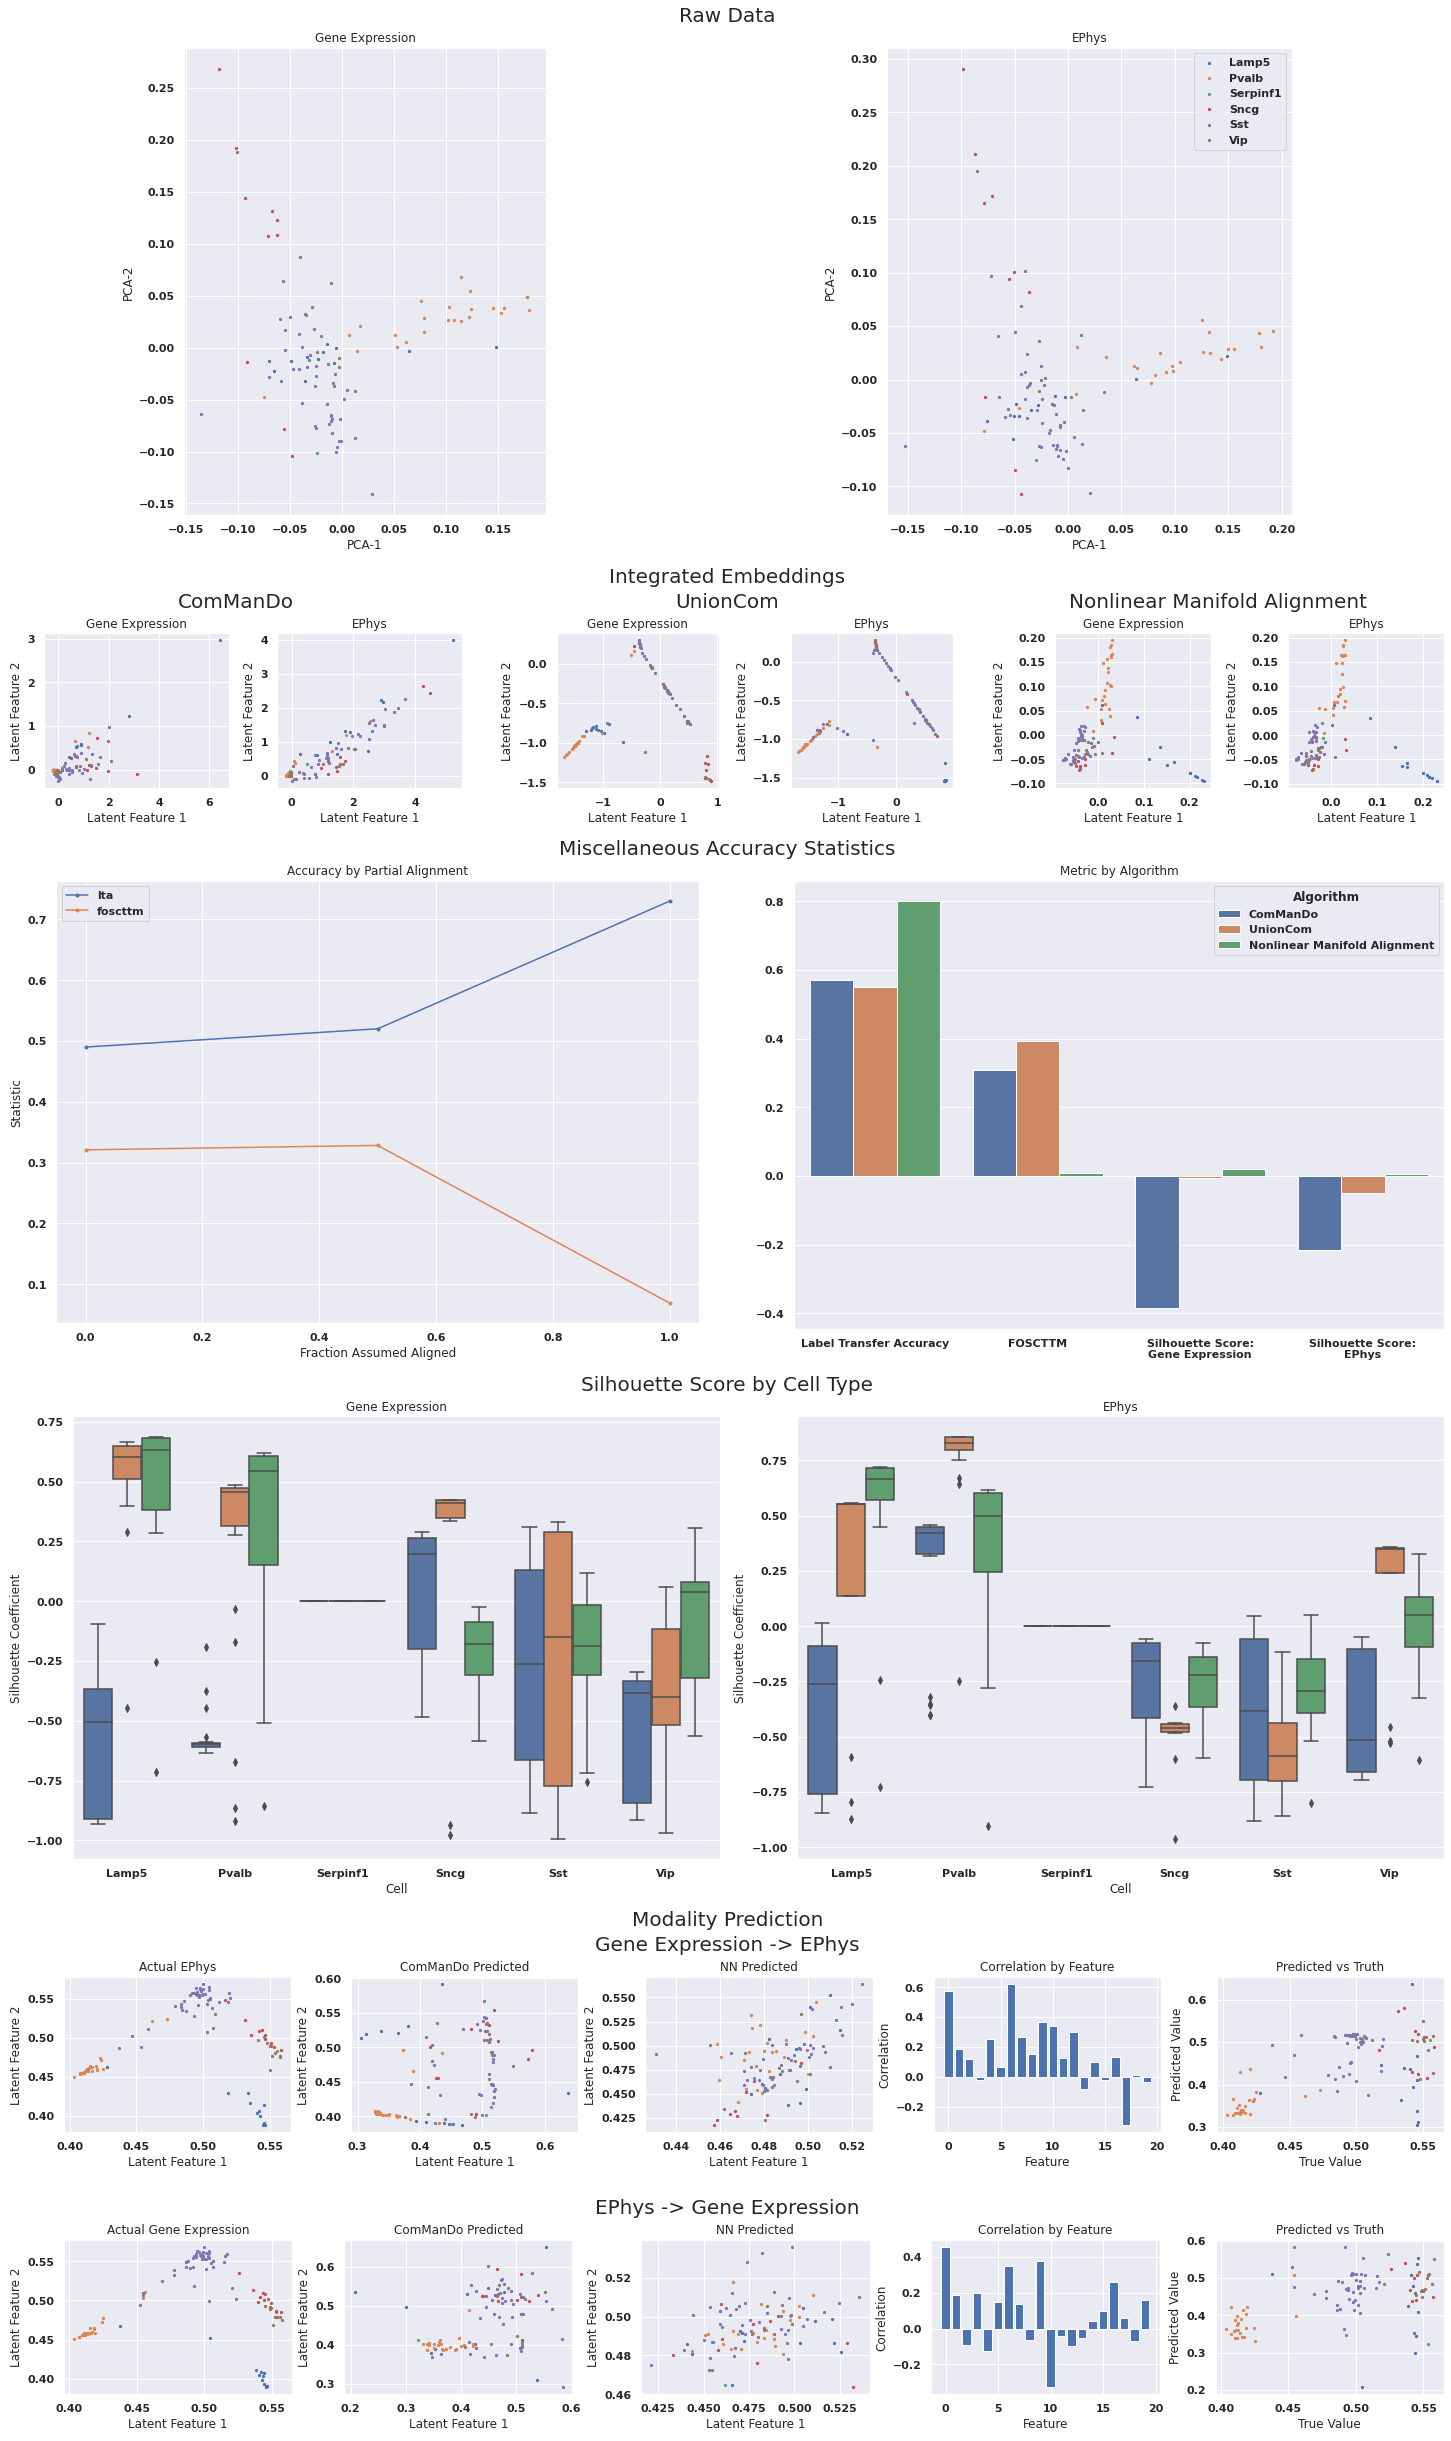

In [8]:
params = {
    'dataset_names': ['Gene Expression', 'EPhys'],
    'alg_results': [uc_data, nl_data],
    'alg_names': ['UnionCom', 'Nonlinear Manifold Alignment'],
    'scale': 20,
    # 'skip_partial': True,
    # 'skip_nn': True,
}
generate_figure(cm, cm_data, dataset, labels, **params)